In [30]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [31]:
import pandas as pd
import yaml

In [32]:
CONFIG_FILE = "../config/MVP.yaml"

In [33]:
with open(CONFIG_FILE, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [34]:
folder = config["folder_comparison_results"]
folder_additional_data = config["folder_generated_qasm"]

In [35]:
def get_df(file_list, test_name, folder):
    """Read all the json file in a dataframe."""
    all_data = []
    for filename in file_list:
        with open(os.path.join(folder, filename), "r") as f:
            data = json.load(f)
        if test_name == "energy":
            filename = filename.replace("_energy", "")
        data['filename'] = filename
        all_data.append(data)
    df = pd.DataFrame.from_records(all_data)
    df['test_name'] = test_name
    return df


In [36]:
all_files = os.listdir(folder)

energy_files = [
    f 
    for f in all_files
    if f.endswith(".json") and "energy" in f 
]

ks_files = [
    f 
    for f in all_files
    if f.endswith(".json") and not "energy" in f 
]

In [37]:

df_energy = get_df(file_list=energy_files, test_name="energy", folder=folder)
df_ks = get_df(file_list=ks_files, test_name="ks", folder=folder)
df_ks

,statistic,p_value,filename,test_name
0,0.006958,0.988826,1637950927_1664.json,ks
1,0.021606,0.043662,1637950927_7208.json,ks
2,0.499756,0.000000,1637950927_5474.json,ks
3,0.881714,0.000000,1637950927_5804.json,ks
4,0.005005,0.999953,1637950927_1010.json,ks
5,0.466309,0.000000,1637950927_8953.json,ks
6,0.023804,0.019279,1637950927_1354.json,ks
7,0.552246,0.000000,1637950927_5703.json,ks
8,0.020752,0.058733,1637950927_4438.json,ks
9,0.878174,0.000000,1637950927_8479.json,ks


In [38]:
df_all = pd.merge(df_ks, df_energy, on="filename")

In [39]:
df_all

,statistic_x,p_value_x,filename,test_name_x,statistic_y,p_value_y,test_name_y
0,0.006958,0.988826,1637950927_1664.json,ks,1.3150,0.5625,energy
1,0.021606,0.043662,1637950927_7208.json,ks,2.2283,0.3125,energy
2,0.499756,0.000000,1637950927_5474.json,ks,5737.9185,0.0625,energy
3,0.881714,0.000000,1637950927_5804.json,ks,9302.2739,0.0625,energy
4,0.005005,0.999953,1637950927_1010.json,ks,0.3009,0.7500,energy
5,0.466309,0.000000,1637950927_8953.json,ks,2997.1485,0.0625,energy
6,0.023804,0.019279,1637950927_1354.json,ks,1.9117,0.6875,energy
7,0.552246,0.000000,1637950927_5703.json,ks,3685.4737,0.0625,energy
8,0.020752,0.058733,1637950927_4438.json,ks,2.0058,0.3125,energy
9,0.878174,0.000000,1637950927_8479.json,ks,7244.1635,0.0625,energy


(0.0, 1.0)

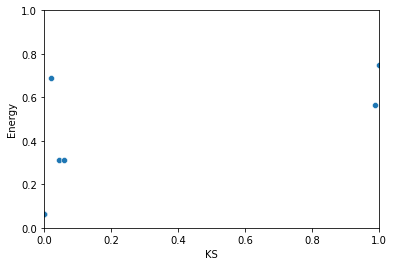

In [40]:
sns.scatterplot(
    data=df_all,
    x="p_value_x",
    y="p_value_y"
)
plt.ylabel("Energy")
plt.xlabel("KS")
plt.ylim(0, 1)
plt.xlim(0, 1)

In [ ]:
all_files = os.listdir(folder)

energy_files = [
    f 
    for f in all_files
    if f.endswith(".json") and "energy" in f 
]

ks_files = [
    f 
    for f in all_files
    if f.endswith(".json") and not "energy" in f 
]

In [42]:
folder_execution = config["folder_execution_results"]
TO_INSPECT = "1637950927_8479"

['1637950927_8479',
 '1637950927_5703',
 '1637950927_5474',
 '1637950927_1010',
 '1637950927_1664',
 '1637950927_5804',
 '1637950927_8953',
 '1637950927_7208',
 '1637950927_1354',
 '1637950927_4438']

In [87]:
def bitflip_distance(a, b):
    y = int(a, 2)^int(b,2)
    xor_string = bin(y)[2:].zfill(len(a))
    #print(xor_string)
    return xor_string.count('1')

In [103]:
import nltk
import numpy as np
from tqdm import tqdm


def inspect(code, p_value, folder, top_k=10, ax=None, verbose=False):
    """Plot the agreement on the most frequent values."""
    platforms = ["QiskitCircuit", "CirqCircuit"]

    records = []

    for platform in platforms:
        with open(os.path.join(folder, code + "_" + platform + ".json"), 'r') as f:
            results = json.load(f)
        if verbose:
            print("-" * 80)
            print(platform)
        ordered = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
        for i, (k, v) in enumerate(ordered.items()):
            if i > top_k:
                break
            if verbose:
                print(k, v)
            record = dict()
            record["value"] = k
            record["shots"] = v
            record["platform"] = platform
            records.append(record)

    list_A = [r for r in records if r["platform"] == "QiskitCircuit"]
    list_B = [r for r in records if r["platform"] == "CirqCircuit"]

    size = len(list_A)
    m = np.zeros((size, size))
    for i, a in enumerate(list_A):
        for j, b in enumerate(list_B):
            
            m[i][j] = bitflip_distance(a["value"], b["value"])
            #m[i][j] = nltk.edit_distance(a["value"], b["value"])

    n_bits = len(records[0]["value"])
    
    cmap_color = "Reds"
    if ax == None:
        sns.heatmap(m, annot=True, cmap=cmap_color, vmin=0, vmax=n_bits)
    else:
        sns.heatmap(m, annot=True, cmap=cmap_color, vmin=0, vmax=n_bits, ax=ax)
    
    ax.set_title(f"{str(n_bits)} bits (pval={p_value})")

10it [00:15,  1.51s/it]


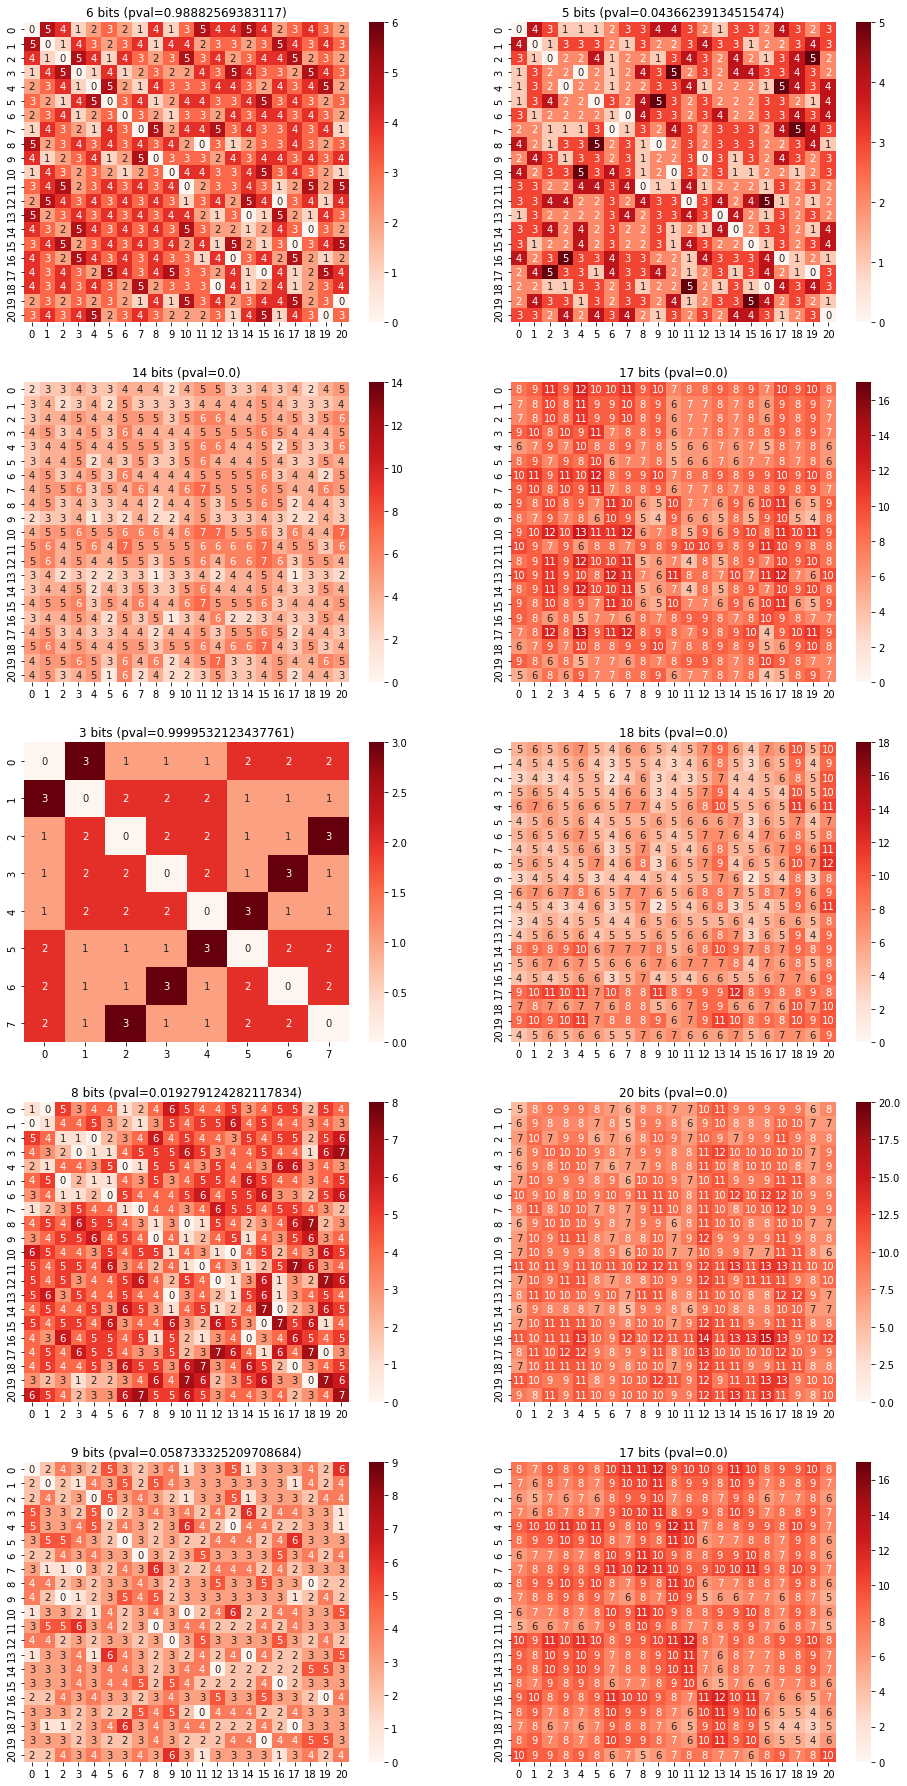

In [110]:
# select df to consider 
df = df_ks

p_values = list(df["p_value"])
all_codes = [f.replace(".json", "") for f in list(df["filename"])]


fig, axes = plt.subplots(5, 2, figsize=(16, 32))
axes = axes.reshape(-1)

TOP_K = 20

for ax, circuit_code, p_value in tqdm(zip(axes, all_codes, p_values)):
    inspect(code=circuit_code, p_value=p_value, folder=folder_execution, top_k=TOP_K, ax=ax)
    